In [4]:
from __future__ import division
import pandas as pd
import numpy as np
from numpy import argmax
from scipy import constants
import random

import os
import sys
import re
import pdb
import glob

import suftware

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
import tensorflow.keras.backend as K
from tensorflow.keras.constraints import non_neg as nonneg

import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#%matplotlib inline
plt.ion()

In [5]:
# Load the energy matrices from Kinney et al. 2010
crp_df = pd.read_csv('data/energy_matrices/crp_tau_final_all.26.txt', sep = "\t", usecols = range(1,5))
rnap_df = pd.read_csv('data/energy_matrices/rnap_tau_final_all.41.txt', sep = "\t", usecols = range(1,5))

# Convert the dataframe to numpy array for downstream processing
crp_array = pd.DataFrame.to_numpy(crp_df)
rnap_array = pd.DataFrame.to_numpy(rnap_df)

In [6]:
def mutate_sequence(con_seq, mut_rate):
    bases = ["A","C","G","T"]
    new_seq = list(con_seq)
    to_mutate = np.random.random(size = len(con_seq)) < mut_rate
    for i in range(0,len(to_mutate)):
        if to_mutate[i]:
            new_seq[i] = random.choice([b for b in bases if b not in new_seq[i]])
    return ''.join(new_seq)

# Fit a label encoder and a onehot encoder
bases = ["A","C","G","T"]
label_encoder = LabelEncoder()
label_encoder.fit(bases)
tmp = label_encoder.transform(bases)
tmp = tmp.reshape(len(tmp), 1)
onehot_encoder = OneHotEncoder(sparse = False)
onehot_encoder.fit(tmp)

# Encode sequence into onehot
def onehot_sequence(sequence, lab_encoder = label_encoder, one_encoder = onehot_encoder):
    """Sequence as a string"""
    tmp = lab_encoder.transform(list(sequence))
    tmp = tmp.reshape(len(tmp),1)
    tmp = one_encoder.transform(tmp)
    return tmp

# Calculate energy
def get_energy(seq_onehot, matrix_array):
    return np.sum(matrix_array * seq_onehot)

# Calculate boltzmann weight
def get_transcription(energy,mu=2.7):
    tau_max = 1.00
    return tau_max*(np.exp(-(energy-mu))/(1+np.exp(-(energy-mu))))

In [7]:
# Set up parameters
gaps = 7 # Length of gaps between CRP and RNAP binding sites
c_r = 5.94e-3 # Concentration of RNAP; Empirically determined
c_c = 10 ** -1.2 # Concentration of active CRP
e_i = -3.26 # Energy of interaction
t_bg = 0.01 # Background noise
consensus_sequence = "AATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG"
crp_wt_energy = 6.9 # From Kinney et al. 2010
rnap_wt_energy = 8.3 # From Kinney et al. 2010

In [8]:
# Create a single energy matrix
energy_array = np.concatenate((crp_array, np.zeros([gaps,4]), rnap_array))

# Obtain positional information from the parameters given
crp_start = 1
crp_end = crp_start + len(crp_array)
gap_start = crp_end
gap_end = gap_start + gaps
rnap_start = gap_end
rnap_end = rnap_start + len(rnap_array)

In [9]:
#input_data_crp = pd.read_csv('crp-wt/data.txt',delim_whitespace=True)
input_data_full_wt = pd.read_csv('data/full-wt/data.txt',delim_whitespace=True)

In [11]:
input_data_full_wt

,seq,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9
0,AAAAAAAGTGAGTTAGCCAACTAATTAGGCACCGTACGCTTTATAG...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AAAAAATCTGAGTTAGCTTACTCATTAGGCACCCCAGGCTTGACAC...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,AAAAAATCTGAGTTTGCTCACTCTATCGGCACCCCAGTCTTTACAC...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,AAAAAATGAGAGTTAGTTCACTCATTCGGCACCACAGGCTTTACAA...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,AAAAAATGGGTGTTAGCTCTATCATTAGGCACCCCCGGCTTTACAC...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
50513,TTTTGCAGAGTGTCAGCCCACTCATTACGCACCGCAGCCGTTACAC...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
50514,TTTTTATGTGAGTTAGCTCACTCATTCGGCACCCTAGGCTTTACAC...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
50515,TTTTTATGTGAGTTTGCTCACTCATGTGGCACCTAAGGCTTTACGC...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50516,TTTTTATGTGGGTTAGGTCGCGCATTAGGCACCGCAGGCTTTACCC...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
sequences = []
bin_number = []

for _ in range(len(input_data_full_wt)):
    sequences.append(input_data_full_wt['seq'][_])
    bin_number.append(list(input_data_full_wt.iloc[_,1:len(input_data_full_wt.columns)].values))

In [13]:
bin_number

[[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,

In [10]:
# plt.hist(bin_number,bins=40)
# plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(sequences, bin_number, test_size=0.2)

In [15]:
# plt.hist(y_train,bins=40,alpha=0.5,density=True)
# plt.hist(y_test,bins=40,alpha=0.5,density=True)
# plt.show()

In [16]:
np.shape(y_train)

(40414, 10)

In [14]:
#len(X_train[0][1:27]+X_train[0][33:74])

In [17]:
######
## Define custom function for keras
######

def log_poisson_loss(y_true, y_pred):
    return tf.nn.log_poisson_loss(y_true,y_pred)

def poisson_loss(y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    return K.mean(y_pred - y_true * math_ops.log(y_pred + K.epsilon()), axis=-1)


In [18]:
# convert the crp part of the sequence to one hot encoding
input_seqs_ohe = []
for _ in range(len(X_train)):
    #input_seqs_ohe.append(onehot_sequence(X_train[_][1:27]+X_train[_][33:74]))
    input_seqs_ohe.append(onehot_sequence(X_train[_][1:27]+X_train[_][34:75]))
    
test_seqs_ohe = []    
for _ in range(len(X_test)):
    #test_seqs_ohe.append(onehot_sequence(X_test[_][1:27]+X_test[_][33:74]))
    test_seqs_ohe.append(onehot_sequence(X_test[_][1:27]+X_test[_][34:75]))

In [85]:
#len(X_train[1:27])*4
len(X_train[34:75])

41

In [19]:
print(np.shape(input_seqs_ohe))
print(np.shape(test_seqs_ohe))

(40414, 67, 4)
(10104, 67, 4)


In [18]:
# # one-hot encoding for y-labels

# number_bins = 10

# def int_to_onehot(n, n_classes):
#     v = [0] * n_classes
#     v[n] = 1
#     return v

# y_train_ohe = []
# y_test_ohe = []

# for _ in range(len(y_train)):
#     y_train_ohe.append(int_to_onehot(y_train[_], number_bins))
    
# for _ in range(len(y_test)):
#     y_test_ohe.append(int_to_onehot(y_test[_], number_bins))    

In [20]:
y_train_ohe = y_train.copy()
y_test_ohe = y_test.copy()

In [21]:
np.shape(y_train_ohe[1])[0]

10

In [22]:
number_input_layer_nodes = len(input_seqs_ohe[0])*4 +1   
inputTensor = Input((number_input_layer_nodes,),name='Sequence')

In [33]:
#import tensorflow as tf
from tensorflow.keras.layers import multiply

class CustomConnected(Dense):

    def __init__(self,units,connections, output_dim,**kwargs):
        
        self.output_dim = output_dim
        #this is matrix of connections. I.e., this should be [0,0,trainable,trainable]
        self.connections = connections                        
        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  


    def call(self, inputs):
        #print(self.connections)
        
        #kernel_times_connections = multiply([self.kernel, self.connections])
        #output = K.dot(inputs, self.kernel * self.connections)
        kernel_times_connections = self.kernel*self.connections
        
        # for implementing custom constraint, print out kernel. Set last two elements equal to each other.
        output = K.dot(inputs,kernel_times_connections)

        #print('outputs: ',output)
        #print('inputs: ',inputs)
        #print('kernel',self.kernel)
        
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    

In [34]:
#from tensorflow.keras import layers
from tensorflow.keras import layers
import tensorflow as tf


class CustomSoftmax(layers.Layer):

    def __init__(self, units=4, input_dim=2,output_dim=4):
        self.output_dim = output_dim
        super(CustomSoftmax, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal',
                                 name='weights',
                                 trainable=False)
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros',
                                 name='bias',
                                 trainable=True)

    def call(self, inputs):
        
        #return K.dot(inputs, self.w) + self.b
        #return K.dot(self.w,inputs) + self.b
        #return tf.matmul(inputs, self.w) + self.b
        output = tf.nn.softmax(tf.matmul(inputs, self.w) + self.b) 
        print('output:',output)
        return output

In [35]:
# this layer keeps weights non-trainable and biases traianable 
class CustomSoftmax2(layers.Layer):

    def __init__(self, units=4, input_dim=2,output_dim=4):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.units = units
        super(CustomSoftmax2, self).__init__()
        
    
    def build(self, input_shape): 
        
        self.w = self.add_weight(shape=(self.input_dim, self.units),
                                 initializer='random_normal',
                                 name='weights',
                                 trainable=False)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 name='bias',
                                 trainable=True)
        
        super(CustomSoftmax2, self).build(input_shape)    

    def call(self, inputs):
        
        #return K.dot(inputs, self.w) + self.b
        #return K.dot(self.w,inputs) + self.b
        #return tf.matmul(inputs, self.w) + self.b
        output = tf.nn.softmax(tf.matmul(inputs, self.w) + self.b) 
        print('output:',output)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [36]:
# this layer keeps weights non-trainable and biases traianable 
# with the first 3 values of the bias fixed to 0 so that the last
# trainable value represents interactions energy

from tensorflow.keras.layers import multiply
class CustomSoftmax3(layers.Layer):

    def __init__(self, units=4, input_dim=2,output_dim=4):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.units = units
        super(CustomSoftmax3, self).__init__()
        
    
    def build(self, input_shape): 
        
        self.w = self.add_weight(shape=(self.input_dim, self.units),
                                 initializer='random_normal',
                                 name='weights',
                                 trainable=False)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 name='bias',
                                 trainable=True)
        
        super(CustomSoftmax3, self).build(input_shape)    

    def call(self, inputs):
        

        #output = tf.nn.softmax(tf.matmul(inputs, self.w) + self.b)
        output = tf.nn.softmax(tf.matmul(inputs, self.w) + multiply([self.b,tf.constant([0.0,0.0,0.0,1.0])])) 
        print('input',inputs)
        print('weight: ',self.w)
        print('input*weight',tf.matmul(inputs, self.w))
        print('output:',output)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [37]:
# define two groups which represent binding sites for the two proteins crp and rnap

group1 = Lambda(lambda x: x[:,0:104], output_shape=((104,)))(inputTensor)
group2 = Lambda(lambda x: x[:,104:268], output_shape=((164,)))(inputTensor)
group3 = Lambda(lambda x: x[:,268:269], output_shape=((1,)))(inputTensor)


# From input to first hidden layer. The groups are connected to two nodes
# node group1 represents energy of crp and group2 represents rnap energy.

# rename group1 to crp pwm

group1 = Dense(1,use_bias=True,name='CRP_pwm')(group1)
group2 = Dense(1,use_bias=True,name='RNAP_pwm')(group2)
group3 = Dense(1,use_bias=False,name='one-feature')(group3)

#group2 = Dense(1,use_bias=False,name='RNAP_pwm',kernel_initializer='RandomNormal',W_constraint=nonneg())(group2)

# the groups from the previous layer have to be concatenated so
concatenateLayer = Concatenate()([group1,group2,group3])

# gammaInput = Input(shape=(1,),name='gamma_Input')   # i.e. weights going into softmax: [0,0,0,1]
# concatenateLayer_with_gamma = Concatenate()([group1,group2,gammaInput])


# softmax layer needs to have multiple inputs

# try custom connections in the trainable softmax
#softmaxLayer = Dense(4,activation='softmax', trainable=True, use_bias=True,name='softmax_layer')(concatenateLayer)
#softmaxLayer = CustomSoftmax(4,2)(concatenateLayer)
#softmaxLayer = CustomSoftmax2(4,input_dim= 2,output_dim=4)(concatenateLayer)
#softmaxLayer = CustomSoftmax3(4,input_dim= 2,output_dim=4)(concatenateLayer)
softmaxLayer = Dense(4,activation='softmax', trainable=False, use_bias=False,name='softmax_layer')(concatenateLayer)

# tauTensor = CustomConnected(1,tf.constant([0.0,0.0,1.0,1.0]),1,use_bias=False,name='custom_tau_layer')(softmaxLayer)
# outputTensor = Dense(np.shape(y_train_ohe[1])[0],activation='softmax', trainable=True, use_bias=False,name='softmax_layer_bins')(tauTensor)

tauTensor = CustomConnected(1,tf.constant([0.0,0.0,4.0,4.0]),1,use_bias=False,name='custom_tau_layer',trainable=False)(softmaxLayer)
intermediateTensor = Dense(10,activation='softmax', trainable=True, use_bias=False,name='softmax_layer_intermediate',kernel_constraint=nonneg())(tauTensor)
outputTensor = Dense(np.shape(y_train_ohe[1])[0],activation='softmax', trainable=True, use_bias=False,name='softmax_layer_bins',kernel_constraint=nonneg())(intermediateTensor)


#create the model:
model = Model(inputTensor,outputTensor)
# model = Model(inputs=[inputTensor, gammaInput], outputs=outputTensor)



In [27]:
# # old model
# # define two groups which represent binding sites for the two proteins crp and rnap

# group1 = Lambda(lambda x: x[:,0:104], output_shape=((104,)))(inputTensor)
# group2 = Lambda(lambda x: x[:,104:268], output_shape=((164,)))(inputTensor)


# # From input to first hidden layer. The groups are connected to two nodes
# # node group1 represents energy of crp and group2 represents rnap energy.

# # rename group1 to crp pwm

# group1 = Dense(1,use_bias=False,name='CRP_pwm')(group1)
# group2 = Dense(1,use_bias=False,name='RNAP_pwm')(group2)

# #group2 = Dense(1,use_bias=False,name='RNAP_pwm',kernel_initializer='RandomNormal',W_constraint=nonneg())(group2)

# # the groups from the previous layer have to be concatenated so
# concatenateLayer = Concatenate()([group1,group2])

# # gammaInput = Input(shape=(1,),name='gamma_Input')   # i.e. weights going into softmax: [0,0,0,1]
# # concatenateLayer_with_gamma = Concatenate()([group1,group2,gammaInput])


# # softmax layer needs to have multiple inputs

# # try custom connections in the trainable softmax
# #softmaxLayer = Dense(4,activation='softmax', trainable=True, use_bias=True,name='softmax_layer')(concatenateLayer)
# #softmaxLayer = CustomSoftmax(4,2)(concatenateLayer)
# #softmaxLayer = CustomSoftmax2(4,input_dim= 2,output_dim=4)(concatenateLayer)
# softmaxLayer = CustomSoftmax3(4,input_dim= 2,output_dim=4)(concatenateLayer)
# #softmaxLayer = Dense(4,activation='softmax', trainable=False, use_bias=True,name='softmax_layer')(concatenateLayer_with_gamma)

# # tauTensor = CustomConnected(1,tf.constant([0.0,0.0,1.0,1.0]),1,use_bias=False,name='custom_tau_layer')(softmaxLayer)
# # outputTensor = Dense(np.shape(y_train_ohe[1])[0],activation='softmax', trainable=True, use_bias=False,name='softmax_layer_bins')(tauTensor)

# tauTensor = CustomConnected(1,tf.constant([0.0,0.0,1.0,1.0]),1,use_bias=False,name='custom_tau_layer')(softmaxLayer)
# intermediateTensor = Dense(10,activation='softmax', trainable=True, use_bias=False,name='softmax_layer_intermediate')(tauTensor)
# outputTensor = Dense(np.shape(y_train_ohe[1])[0],activation='softmax', trainable=True, use_bias=False,name='softmax_layer_bins')(intermediateTensor)


# #create the model:
# model = Model(inputTensor,outputTensor)
# # model = Model(inputs=[inputTensor, gammaInput], outputs=outputTensor)



In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence (InputLayer)           [(None, 269)]        0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 104)          0           Sequence[0][0]                   
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 164)          0           Sequence[0][0]                   
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 1)            0           Sequence[0][0]                   
______________________________________________________________________________________________

In [39]:
model.layers

In [40]:
print(np.shape(model.layers[4].get_weights()))
print(np.shape(model.layers[5].get_weights()))
print(np.shape(model.layers[6].get_weights()))

(2,)
(2,)
(1, 1, 1)


/Users/tareen/miniconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [41]:
print(model.layers[6].get_weights())

[array([[1.6104857]], dtype=float32)]


### Set initial weights for last layer...
...so that only the last two states (S3 and S4 in write-up) contribute to transcription

In [42]:
tau_layer_weights = model.layers[9].get_weights()[0].copy()
tau_layer_weights.shape

(4, 1)

In [43]:
tau_layer_initial_weights = np.array([0,0,4,4])
tau_layer_initial_weights = tau_layer_initial_weights.reshape(4,1)
model.layers[9].set_weights([tau_layer_initial_weights])
model.layers[9].get_weights()[0]

array([[0.],
       [0.],
       [4.],
       [4.]], dtype=float32)

### The following show non-trainable and trainable weights in the softmax layer

In [44]:
# these weights appear to be in reverse order. 
print(model.layers[8].get_weights())


[array([[-0.8239767 ,  0.29193997,  0.86659217, -0.5734676 ],
       [-0.06353569,  0.83071613, -0.2505237 , -0.03162855],
       [-0.47523886,  0.20964217,  0.05518186, -0.55150795]],
      dtype=float32)]


### Set softmax layer weights manually, will be kept frozen during training
Note that the bias weights here may be interpreted as gamma

In [45]:
# the following are the input weights to the softmax array.
# the first two arrays indicate 4 weights each coming out of the e_c and 
# e_r nodes. The last node indicates the gamma input, connecting only to
# microstate 4.

#softmax_weights = np.array([[0,1,0,1],[0,0,1,1]]) # this works
softmax_weights = np.array([[0,1,0,1],[0,0,1,1],[0,0,0,1]]) # this works
#softmax_weights = np.array([[0,0,1,1],[0,1,0,1]])
#softmax_biases = np.array([0,0,0,1])

# keras' set_weights expects weights and bias in a list
#softmax_weights = [softmax_biases,softmax_weights]

# without bias
softmax_weights = [softmax_weights]

# set weights
model.layers[8].set_weights(softmax_weights)
# see set weights
model.layers[8].get_weights()

[array([[0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], dtype=float32)]

## Compile model

In [46]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.0005), metrics=['mean_absolute_error'])
#model.compile(loss='mean_squared_error',optimizer=sgd, metrics=['mean_absolute_error'])

In [47]:
np.array(X_train).shape[0]

40414

In [48]:
np.shape(input_seqs_ohe[_].flatten())
temp = input_seqs_ohe[0].flatten()
temp = np.append(temp,1)
temp.shape

(269,)

In [49]:
input_sequences_tensor2 = []
test_input_sequences_tensor2 = []

for _ in range(len(input_seqs_ohe)):
    temp = input_seqs_ohe[_].flatten()
    temp = np.append(temp,1)
    #input_seqs_ohe[_] = np.append(input_seqs_ohe[_],1)
    input_sequences_tensor2.append(temp)
    
for _ in range(len(test_seqs_ohe)):
    
    temp = test_seqs_ohe[_].flatten()
    temp = np.append(temp,1)
    test_input_sequences_tensor2.append(temp)

In [50]:
input_sequences_tensor2 = np.array(input_sequences_tensor2)
test_input_sequences_tensor2 = np.array(test_input_sequences_tensor2)

In [51]:
input_sequences_tensor2[0].shape

(269,)

In [52]:
# input_seqs_ohe = np.array(input_seqs_ohe)
# input_sequences_tensor = input_seqs_ohe.reshape(-1,len(input_seqs_ohe[0])*4+1)

# test_seqs_ohe = np.array(test_seqs_ohe)
# test_input_sequences_tensor = test_seqs_ohe.reshape(-1,len(test_seqs_ohe[0])*4+1)

labels = np.array(y_train_ohe)
test_labels = np.array(y_test_ohe)

In [53]:
input_sequences_tensor2[0]

array([0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0.

In [54]:
######
## Define custom function for keras
######

def log_poisson_loss(y_true, y_pred):
    return tf.nn.log_poisson_loss(y_true,y_pred)

def poisson_loss(y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    return K.mean(y_pred - y_true * math_ops.log(y_pred + K.epsilon()), axis=-1)


In [55]:
#model.compile(loss=log_poisson_loss,optimizer=Adam(lr=0.00001), metrics=['categorical_accuracy'])
model.compile(loss=log_poisson_loss,optimizer=Adam(lr=0.0001), metrics=['categorical_accuracy'])

In [56]:
# history = model.fit([input_sequences_tensor,gamma_input_list], labels, 
#                     validation_split=0.1, epochs=100,verbose=1,callbacks=[esCallBack,tbCallBack])  

history = model.fit(input_sequences_tensor2, labels, validation_split=0.2, epochs=500,verbose=1)

Epoch 1/500
1011/1011 [==============================] - 2s 1ms/step - loss: 1.0918 - categorical_accuracy: 0.1016 - val_loss: 1.0917 - val_categorical_accuracy: 0.1008
Epoch 2/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0917 - categorical_accuracy: 0.0997 - val_loss: 1.0917 - val_categorical_accuracy: 0.1026
Epoch 3/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0916 - categorical_accuracy: 0.1077 - val_loss: 1.0917 - val_categorical_accuracy: 0.1116
Epoch 4/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0916 - categorical_accuracy: 0.1174 - val_loss: 1.0917 - val_categorical_accuracy: 0.1154
Epoch 5/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0916 - categorical_accuracy: 0.1226 - val_loss: 1.0917 - val_categorical_accuracy: 0.1178
Epoch 6/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0917 - categorical_accuracy: 0.1225 - val_loss: 1.0916 - val_categorical_acc

1011/1011 [==============================] - 1s 1ms/step - loss: 1.0885 - categorical_accuracy: 0.1812 - val_loss: 1.0883 - val_categorical_accuracy: 0.1902
Epoch 50/500
1011/1011 [==============================] - 1s 977us/step - loss: 1.0885 - categorical_accuracy: 0.1807 - val_loss: 1.0883 - val_categorical_accuracy: 0.1902
Epoch 51/500
1011/1011 [==============================] - 1s 975us/step - loss: 1.0885 - categorical_accuracy: 0.1840 - val_loss: 1.0882 - val_categorical_accuracy: 0.1900
Epoch 52/500
1011/1011 [==============================] - 1s 975us/step - loss: 1.0884 - categorical_accuracy: 0.1832 - val_loss: 1.0882 - val_categorical_accuracy: 0.1900
Epoch 53/500
1011/1011 [==============================] - 1s 991us/step - loss: 1.0882 - categorical_accuracy: 0.1844 - val_loss: 1.0882 - val_categorical_accuracy: 0.1910
Epoch 54/500
1011/1011 [==============================] - 1s 969us/step - loss: 1.0882 - categorical_accuracy: 0.1849 - val_loss: 1.0881 - val_categorical_

Epoch 97/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0869 - categorical_accuracy: 0.2066 - val_loss: 1.0867 - val_categorical_accuracy: 0.2171
Epoch 98/500
1011/1011 [==============================] - 1s 981us/step - loss: 1.0869 - categorical_accuracy: 0.2110 - val_loss: 1.0867 - val_categorical_accuracy: 0.2221
Epoch 99/500
1011/1011 [==============================] - 1s 977us/step - loss: 1.0867 - categorical_accuracy: 0.2095 - val_loss: 1.0866 - val_categorical_accuracy: 0.2232
Epoch 100/500
1011/1011 [==============================] - 1s 974us/step - loss: 1.0868 - categorical_accuracy: 0.2158 - val_loss: 1.0866 - val_categorical_accuracy: 0.2236
Epoch 101/500
1011/1011 [==============================] - 1s 994us/step - loss: 1.0868 - categorical_accuracy: 0.2143 - val_loss: 1.0865 - val_categorical_accuracy: 0.2239
Epoch 102/500
1011/1011 [==============================] - 1s 979us/step - loss: 1.0867 - categorical_accuracy: 0.2204 - val_loss: 1.0865 - 

1011/1011 [==============================] - 1s 1ms/step - loss: 1.0854 - categorical_accuracy: 0.2595 - val_loss: 1.0851 - val_categorical_accuracy: 0.2656
Epoch 145/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0854 - categorical_accuracy: 0.2644 - val_loss: 1.0851 - val_categorical_accuracy: 0.2677
Epoch 146/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0853 - categorical_accuracy: 0.2587 - val_loss: 1.0850 - val_categorical_accuracy: 0.2652
Epoch 147/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0854 - categorical_accuracy: 0.2598 - val_loss: 1.0850 - val_categorical_accuracy: 0.2665
Epoch 148/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0852 - categorical_accuracy: 0.2613 - val_loss: 1.0850 - val_categorical_accuracy: 0.2683
Epoch 149/500
1011/1011 [==============================] - 1s 988us/step - loss: 1.0854 - categorical_accuracy: 0.2619 - val_loss: 1.0850 - val_categorical_acc

Epoch 192/500
1011/1011 [==============================] - 1s 981us/step - loss: 1.0847 - categorical_accuracy: 0.2715 - val_loss: 1.0843 - val_categorical_accuracy: 0.2755
Epoch 193/500
1011/1011 [==============================] - 1s 978us/step - loss: 1.0845 - categorical_accuracy: 0.2770 - val_loss: 1.0843 - val_categorical_accuracy: 0.2781
Epoch 194/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0845 - categorical_accuracy: 0.2773 - val_loss: 1.0843 - val_categorical_accuracy: 0.2777
Epoch 195/500
1011/1011 [==============================] - 1s 984us/step - loss: 1.0848 - categorical_accuracy: 0.2732 - val_loss: 1.0843 - val_categorical_accuracy: 0.2779
Epoch 196/500
1011/1011 [==============================] - 1s 989us/step - loss: 1.0846 - categorical_accuracy: 0.2769 - val_loss: 1.0843 - val_categorical_accuracy: 0.2764
Epoch 197/500
1011/1011 [==============================] - 1s 975us/step - loss: 1.0844 - categorical_accuracy: 0.2747 - val_loss: 1.0843

1011/1011 [==============================] - 1s 980us/step - loss: 1.0841 - categorical_accuracy: 0.2848 - val_loss: 1.0839 - val_categorical_accuracy: 0.2841
Epoch 240/500
1011/1011 [==============================] - 1s 994us/step - loss: 1.0842 - categorical_accuracy: 0.2830 - val_loss: 1.0839 - val_categorical_accuracy: 0.2823
Epoch 241/500
1011/1011 [==============================] - 1s 998us/step - loss: 1.0841 - categorical_accuracy: 0.2841 - val_loss: 1.0839 - val_categorical_accuracy: 0.2822
Epoch 242/500
1011/1011 [==============================] - 1s 991us/step - loss: 1.0841 - categorical_accuracy: 0.2826 - val_loss: 1.0839 - val_categorical_accuracy: 0.2838
Epoch 243/500
1011/1011 [==============================] - 1s 991us/step - loss: 1.0841 - categorical_accuracy: 0.2829 - val_loss: 1.0839 - val_categorical_accuracy: 0.2845
Epoch 244/500
1011/1011 [==============================] - 1s 999us/step - loss: 1.0843 - categorical_accuracy: 0.2807 - val_loss: 1.0839 - val_categ

1011/1011 [==============================] - 1s 987us/step - loss: 1.0839 - categorical_accuracy: 0.2866 - val_loss: 1.0837 - val_categorical_accuracy: 0.2870
Epoch 287/500
1011/1011 [==============================] - 1s 989us/step - loss: 1.0839 - categorical_accuracy: 0.2893 - val_loss: 1.0837 - val_categorical_accuracy: 0.2886
Epoch 288/500
1011/1011 [==============================] - 1s 983us/step - loss: 1.0839 - categorical_accuracy: 0.2918 - val_loss: 1.0837 - val_categorical_accuracy: 0.2883
Epoch 289/500
1011/1011 [==============================] - 1s 981us/step - loss: 1.0837 - categorical_accuracy: 0.2910 - val_loss: 1.0837 - val_categorical_accuracy: 0.2892
Epoch 290/500
1011/1011 [==============================] - 1s 992us/step - loss: 1.0840 - categorical_accuracy: 0.2905 - val_loss: 1.0836 - val_categorical_accuracy: 0.2878
Epoch 291/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0840 - categorical_accuracy: 0.2863 - val_loss: 1.0836 - val_categor

1011/1011 [==============================] - 1s 997us/step - loss: 1.0835 - categorical_accuracy: 0.2921 - val_loss: 1.0835 - val_categorical_accuracy: 0.2915
Epoch 334/500
1011/1011 [==============================] - 1s 950us/step - loss: 1.0838 - categorical_accuracy: 0.2918 - val_loss: 1.0835 - val_categorical_accuracy: 0.2880
Epoch 335/500
1011/1011 [==============================] - 1s 978us/step - loss: 1.0839 - categorical_accuracy: 0.2956 - val_loss: 1.0835 - val_categorical_accuracy: 0.2892
Epoch 336/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0838 - categorical_accuracy: 0.2916 - val_loss: 1.0835 - val_categorical_accuracy: 0.2912
Epoch 337/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0835 - categorical_accuracy: 0.2937 - val_loss: 1.0835 - val_categorical_accuracy: 0.2901
Epoch 338/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0838 - categorical_accuracy: 0.2944 - val_loss: 1.0835 - val_categorical

1011/1011 [==============================] - 1s 933us/step - loss: 1.0837 - categorical_accuracy: 0.2945 - val_loss: 1.0834 - val_categorical_accuracy: 0.2926
Epoch 381/500
1011/1011 [==============================] - 1s 936us/step - loss: 1.0835 - categorical_accuracy: 0.2956 - val_loss: 1.0834 - val_categorical_accuracy: 0.2941
Epoch 382/500
1011/1011 [==============================] - 1s 936us/step - loss: 1.0833 - categorical_accuracy: 0.2966 - val_loss: 1.0834 - val_categorical_accuracy: 0.2937
Epoch 383/500
1011/1011 [==============================] - 1s 929us/step - loss: 1.0835 - categorical_accuracy: 0.2932 - val_loss: 1.0834 - val_categorical_accuracy: 0.2932
Epoch 384/500
1011/1011 [==============================] - 1s 930us/step - loss: 1.0836 - categorical_accuracy: 0.2943 - val_loss: 1.0834 - val_categorical_accuracy: 0.2932
Epoch 385/500
1011/1011 [==============================] - 1s 932us/step - loss: 1.0836 - categorical_accuracy: 0.2947 - val_loss: 1.0834 - val_categ

1011/1011 [==============================] - 1s 932us/step - loss: 1.0836 - categorical_accuracy: 0.2910 - val_loss: 1.0833 - val_categorical_accuracy: 0.2946
Epoch 428/500
1011/1011 [==============================] - 1s 936us/step - loss: 1.0835 - categorical_accuracy: 0.3001 - val_loss: 1.0833 - val_categorical_accuracy: 0.2949
Epoch 429/500
1011/1011 [==============================] - 1s 936us/step - loss: 1.0834 - categorical_accuracy: 0.2992 - val_loss: 1.0833 - val_categorical_accuracy: 0.2946
Epoch 430/500
1011/1011 [==============================] - 1s 945us/step - loss: 1.0836 - categorical_accuracy: 0.2965 - val_loss: 1.0833 - val_categorical_accuracy: 0.2944
Epoch 431/500
1011/1011 [==============================] - 1s 953us/step - loss: 1.0839 - categorical_accuracy: 0.2924 - val_loss: 1.0833 - val_categorical_accuracy: 0.2949
Epoch 432/500
1011/1011 [==============================] - 1s 932us/step - loss: 1.0834 - categorical_accuracy: 0.2987 - val_loss: 1.0833 - val_categ

1011/1011 [==============================] - 1s 1ms/step - loss: 1.0833 - categorical_accuracy: 0.2945 - val_loss: 1.0832 - val_categorical_accuracy: 0.2949
Epoch 475/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0837 - categorical_accuracy: 0.2938 - val_loss: 1.0832 - val_categorical_accuracy: 0.2964
Epoch 476/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0835 - categorical_accuracy: 0.3031 - val_loss: 1.0832 - val_categorical_accuracy: 0.2957
Epoch 477/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0834 - categorical_accuracy: 0.2975 - val_loss: 1.0832 - val_categorical_accuracy: 0.2956
Epoch 478/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0834 - categorical_accuracy: 0.2983 - val_loss: 1.0832 - val_categorical_accuracy: 0.2961
Epoch 479/500
1011/1011 [==============================] - 1s 1ms/step - loss: 1.0835 - categorical_accuracy: 0.2962 - val_loss: 1.0832 - val_categorical_accur

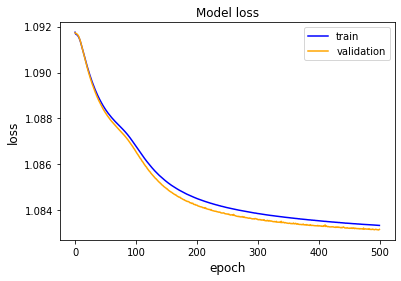

In [57]:
# plot losses

plt.figure()
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='orange')
plt.title('Model loss',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'validation'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

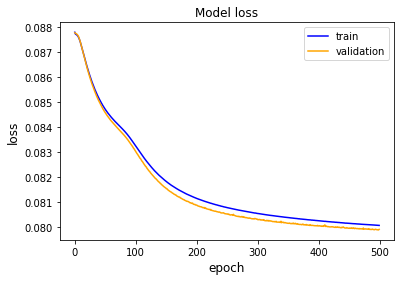

In [58]:
# plot losses

plt.figure()
plt.plot(np.log(history.history['loss']),color='blue')
plt.plot(np.log(history.history['val_loss']),color='orange')
plt.title('Model loss',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'validation'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

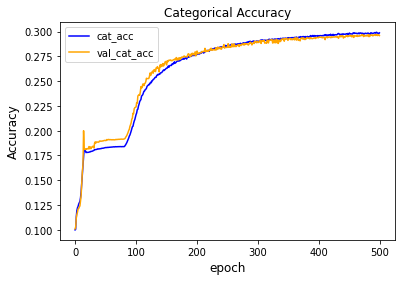

In [59]:
plt.figure()
plt.plot(history.history['categorical_accuracy'],color='blue')
plt.plot(history.history['val_categorical_accuracy'],color='orange')
plt.title('Categorical Accuracy',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['cat_acc', 'val_cat_acc'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

In [60]:
# predictions_on_test = model.predict(test_input_sequences_tensor)
predictions_on_test = model.predict(test_input_sequences_tensor2)

In [61]:
model.evaluate(test_input_sequences_tensor2,test_labels)

316/316 [==============================] - 0s 751us/step - loss: 1.0834 - categorical_accuracy: 0.2985


[1.0833754539489746, 0.29849565029144287]

### First hidden layer weights (PWMs)

Need to input sequence corresponding to CRPs binding site. i.e. fixed the shape of test_input_sequences_tensor

In [62]:
crp_weights = model.layers[4].get_weights()[0].copy()
rnap_weights = model.layers[5].get_weights()[0].copy()

In [63]:
print(model.layers[4].get_weights()[1])
print(model.layers[5].get_weights()[1])

[0.25705916]
[-0.03435827]


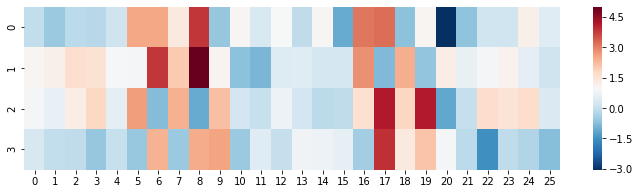

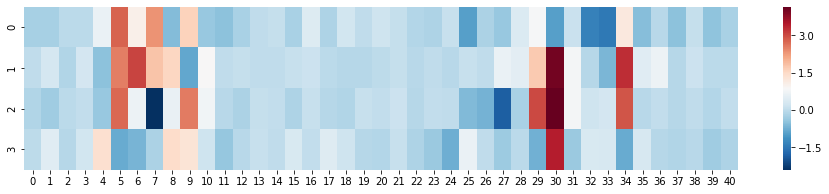

In [64]:
crp_weights = crp_weights.reshape(26,4)
rnap_weights = rnap_weights.reshape(41,4)


plt.figure(figsize=(12,3))
sns.heatmap(crp_weights.T,cmap='RdBu_r')
plt.show()
plt.figure(figsize=(16,3))
sns.heatmap(rnap_weights.T,cmap='RdBu_r')
#sns.heatmap(rnap_weights.T,cmap='RdBu_r')
plt.show()

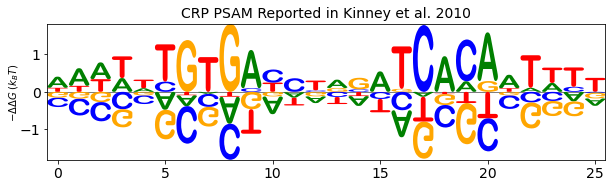

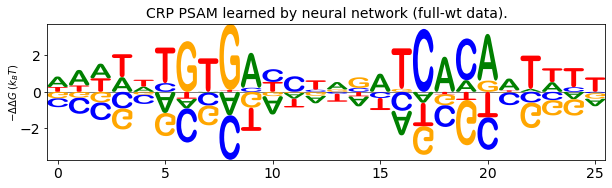

In [65]:
import logomaker
crp_logo_df = pd.DataFrame(crp_weights,columns=['A','C','G','T'])

crp_df.columns = ['A','C','G','T']
logomaker.Logo(-crp_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.tick_params(labelsize=14)
plt.title('CRP PSAM Reported in Kinney et al. 2010',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)
logomaker.Logo(-crp_logo_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.title('CRP PSAM learned by neural network (full-wt data).',fontsize=14)
plt.tick_params(labelsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)

plt.show()
#logomaker.Logo(rnap_logo_df,center_values=True, font_name='Arial Rounded MT Bold')

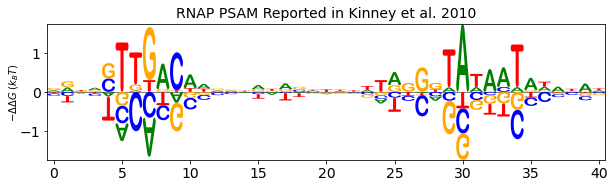

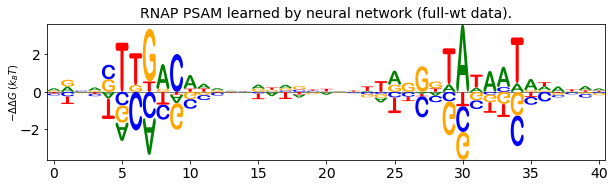

In [66]:
rnap_logo_df = pd.DataFrame(rnap_weights,columns=['A','C','G','T'])
rnap_df.columns = ['A','C','G','T']
logomaker.Logo(-rnap_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.tick_params(labelsize=14)
plt.title('RNAP PSAM Reported in Kinney et al. 2010',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)
logomaker.Logo(-rnap_logo_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.tick_params(labelsize=14)
plt.title('RNAP PSAM learned by neural network (full-wt data).',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)
plt.tick_params(labelsize=14)

In [67]:
learned_delta_G = model.layers[6].get_weights()[0][0][0]/1.62
print(model.layers[6].get_weights()[0][0][0]/1.62,'k_cal/mol')


3.0636696167934088 k_cal/mol


In [68]:
e_i_model = Model(inputs=model.input,outputs=model.layers[6].output)
e_i_node_output = e_i_model.predict([test_input_sequences_tensor2])

In [69]:
e_i_node_output[0]

array([4.963145], dtype=float32)

In [70]:
model.layers[8].get_weights()

[array([[0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], dtype=float32)]

In [71]:
model.layers[9].get_weights()

[array([[0.],
        [0.],
        [4.],
        [4.]], dtype=float32)]

In [72]:
model.layers
# get_1st_layer_output = K.function([model.layers[0].input],[model.layers[1].output])
# layer_output = get_1st_layer_output([x_test_tensor])
# layer_output_train = get_1st_layer_output([x_train_tensor])

In [73]:
model.save(str(learned_delta_G)[:5]+'.h5')

In [74]:
tau_layer_model = Model(inputs=model.input,outputs=model.layers[9].output)
tau_output = tau_layer_model.predict(test_input_sequences_tensor2)

In [75]:
crp_layer_model = Model(inputs=model.input,outputs=model.layers[4].output)
crp_output = crp_layer_model.predict(test_input_sequences_tensor2)

rnap_layer_model = Model(inputs=model.input,outputs=model.layers[5].output)
rnap_output = rnap_layer_model.predict(test_input_sequences_tensor2)

ValueError: x and y must be the same size

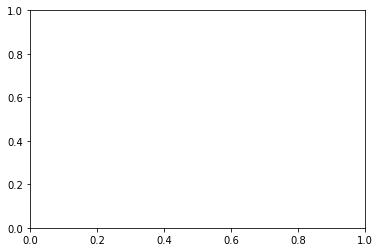

In [76]:
plt.scatter(-crp_output,-tau_output,s=5,alpha=0.1,color='black')
plt.show

In [ ]:
plt.scatter(-rnap_output,-tau_output,s=5,alpha=0.1,color='black')
plt.show

In [ ]:
plt.scatter(-crp_output,-rnap_output,s=5,alpha=0.25,color='black')
plt.show

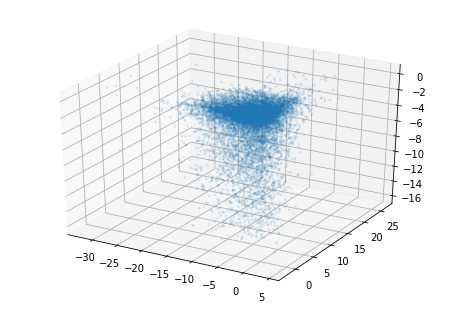

In [69]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)

sequence_containing_x_vals = crp_output
sequence_containing_y_vals = -rnap_output
sequence_containing_z_vals = -tau_output

random.shuffle(sequence_containing_x_vals)
random.shuffle(sequence_containing_y_vals)
random.shuffle(sequence_containing_z_vals)

ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals,s=3,alpha=0.1)
pyplot.show()

In [70]:
break

SyntaxError: 'break' outside loop (cell_name, line 4)

### MI estimation

In [ ]:
tau_layer_model = Model(inputs=model.input,outputs=model.layers[9].output)
tau_output = tau_layer_model.predict(test_input_sequences_tensor2)


In [ ]:
plt.hist(tau_output,bins=40)
plt.show()

In [ ]:
# estimate probability density at each of the output bins using deft. 
import suftware

In [ ]:
softmax_bin_layer_model = Model(inputs=model.input,outputs=model.layers[11].output)
softmax_bin_out = softmax_bin_layer_model.predict(test_input_sequences_tensor2)


In [ ]:
for _ in range(10):
    plt.scatter(tau_output,softmax_bin_out[:,_])
plt.show()

In [ ]:
# y_test -> bin number
# tau_output -> tau
# find p(tau|bin)

total_bins = 10

function_dict = {}

tau_given_bin = {}
for b in range(total_bins):
    temp_tau_given_bin_n = []
    for _ in range(len(y_test)):
        if(y_test[_]==b):
            temp_tau_given_bin_n.append(tau_output[_])
    tau_given_bin[str(b)]= np.array(temp_tau_given_bin_n).flatten()  
    Q_star = suftware.DensityEstimator(np.array(temp_tau_given_bin_n).flatten(),alpha=2).density_func
    print(b)
    function_dict[str(b)] = Q_star

In [ ]:
tau_given_bin['6']

In [ ]:
# rename function dict to Qstar dict, 
# comment out code below
# compute mutual information on full data?

In [ ]:
#suftware.DensityEstimator(np.log(tau_given_bin['6']))
num_gridpoints = 1000
gridpoints = np.linspace(min(tau_output),max(tau_output),num_gridpoints)
h = gridpoints[1] - gridpoints[0]

SMALL = 1E-10
bins = 10

def p_tau_given_bin(x,b):
    key = '%d'%b
    return function_dict[key](x) + SMALL

def p_tau(x):
    tmp = np.zeros(len(x))
    for f in function_dict.values():
        tmp += f(x)
    tmp /= len(function_dict) + SMALL
    return tmp
 
mutual_information = sum([sum(h * p_tau_given_bin(gridpoints,b) * np.log2(p_tau_given_bin(gridpoints,b) / p_tau(gridpoints))) 
                          for b in range(0,bins)]) / bins

print(mutual_information)

In [ ]:
density = suftware.DensityEstimator(np.log(tau_given_bin['4']))
density.plot()

In [ ]:
# 15156 0.5425835651212284
print(len(y_test), mutual_information)

In [ ]:
fig, ax = plt.subplots(nrows=bins,sharex=True, ncols=1,figsize=(10,6))   
ax[0].set_title(r'P($\tau$|bin)')

for bin_index in range(bins):

    for xc in np.log(tau_given_bin[str(bin_index)]):
        
        ax[bin_index].axvline(x=xc,alpha=0.25,linewidth=1,color='lightcoral')
        
    ax[bin_index].set_ylabel(str(bin_index))
    ax[bin_index].set_yticks([])
    
ax[bin_index].set_xlabel(r'$\log(\tau)$')    
fig.text(0.06, 0.5, 'Bin Number', ha='center', va='center', rotation='vertical')    
# plt.savefig('bin_vs_log_tau.pdf')

In [ ]:
# for temp_index in range(10):

#     np.savetxt(str(temp_index)+'.txt',np.log(tau_given_bin[str(temp_index)]))

In [ ]:
print(tf.__version__)
print(keras.__version__)

In [ ]:
#model.save('best_model2_ei_4p7_500_epochs_mi_0p85.h5')

## save files

### save log tau vs. bins

In [ ]:
log_tau_given_bin =  pd.DataFrame(dict([ (k,pd.Series(np.log(v))) for k,v in tau_given_bin.items() ]))
#log_tau_given_bin.to_csv('log_tau_given_bin.csv')

### save inferred logos

In [ ]:
# rnap_logo_df.to_csv('inferred_rnap_matrix.csv')
# (-crp_logo_df).to_csv('inferred_crp_matrix.csv')

In [ ]:
#np.argmax(predictions_on_test[0])
bin_predictions_test = []
for _ in range(len(predictions_on_test)):
    bin_predictions_test.append(np.argmax(predictions_on_test[_]))